In [101]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import detrend
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [102]:
# Descargar datos históricos de Amazon (AMZN) desde enero de 2013 hasta diciembre de 2023
ticker = 'AAPL'
data = yf.download(ticker, start='2014-01-01', end='2024-04-01', interval='1d')

# Mantener solo la columna 'Close'
data = data[['High']]

# Rellenar valores faltantes usando el método forward fill
data.fillna(method='ffill', inplace=True)

# Asegurarse de que no queden valores faltantes
assert data.isnull().sum().sum() == 0, "Aún hay valores faltantes en los datos"

# Aplicar detrend a los datos
#data['Close'] = detrend(data['Close'].values)

# Normalizar los valores de cierre
scaler = MinMaxScaler()
data['High'] = scaler.fit_transform(data['High'].values.reshape(-1, 1)).flatten()

# Generar histogramas 2D en escala de grises
def generate_histograms(data, window_size=50, bins=20):
    histograms = []
    for i in range(len(data) - window_size):
        window_x = data.iloc[i:i+window_size-1].values
        window_y = data.iloc[i+1:i+window_size].values
        hist, xedges, yedges = np.histogram2d(window_x, window_y, bins=bins, range=[[data.min(), data.max()], [data.min(), data.max()]])
        histograms.append(hist)
    return np.array(histograms)

# Generar histogramas 2D
histograms = generate_histograms(data['High'])

# Normalizar histogramas
histograms = histograms / histograms.max()

[*********************100%%**********************]  1 of 1 completed
C:\Users\Carlo\AppData\Local\Temp\ipykernel_10060\3217837635.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_10060\3217837635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_10060\3217837635.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [103]:
# Dividir datos en entrenamiento y prueba
X = np.expand_dims(histograms, axis=-1)
y = data['High'].values[50:]  # Eliminar los primeros 50 valores para que coincidan con el tamaño de los histogramas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir el modelo CNN
model = Sequential([
    Conv2D(1, (3, 3), activation='relu', input_shape=(20, 20, 1)),  # 1 filtro, kernel 3x3
    MaxPooling2D(pool_size=(2, 2)),  # Max-pooling 2x2
    Conv2D(10, (2, 2), activation='relu'),  # 10 filtros, kernel 2x2
    MaxPooling2D(pool_size=(2, 2)),  # Max-pooling 2x2
    Flatten(),  # Aplana el tensor resultante
    Dense(160, activation='relu'),  # Capa fully connected con 160 neuronas
    Dense(1, activation='linear')  # Capa de salida
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=180, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/180


c:\Users\Carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0594 - mae: 0.1846 - val_loss: 0.0501 - val_mae: 0.1835
Epoch 2/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mae: 0.0373 - val_loss: 0.0275 - val_mae: 0.1291
Epoch 3/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0268 - val_mae: 0.1251
Epoch 4/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0309 - val_mae: 0.1411
Epoch 5/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5763e-04 - mae: 0.0210 - val_loss: 0.0186 - val_mae: 0.1027
Epoch 6/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9344e-04 - mae: 0.0192 - val_loss: 0.0235 - val_mae: 0.1226
Epoch 7/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2134e-04 - mae: 0.0196 - val_loss: 0.0158 - val_mae: 0.0995
Epoch 8/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5818e-04 - mae: 0.0178 - val_loss: 0.0181 - val_mae: 0.1074
Epoch 9/180
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4

In [104]:
# Evaluar el modelo
mse, mae = model.evaluate(X_test, y_test)
print(f'MSE: {mse}, MAE: {mae}')

# Predecir valores de entrenamiento y prueba
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()

# Calcular métricas
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f'Train MSE: {train_mse}, Train MAE: {train_mae}, Train R²: {train_r2}')
print(f'Test MSE: {test_mse}, Test MAE: {test_mae}, Test R²: {test_r2}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0108 - mae: 0.0829
MSE: 0.009397064335644245, MAE: 0.07838278263807297
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
Train MSE: 0.0002876376383233452, Train MAE: 0.01347722068810404, Train R²: 0.9950404950246245
Test MSE: 0.009397065115872738, Test MAE: 0.07838279026524636, Test R²: 0.0761541413350304


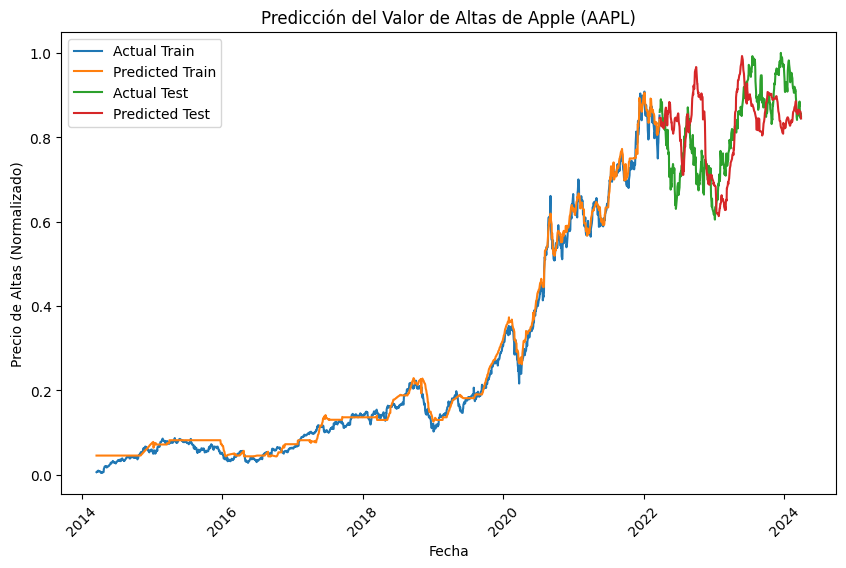

In [105]:
# Crear índices de fechas para los conjuntos de entrenamiento y prueba
train_size = len(y_train)
train_index = data.index[50:50 + train_size]
test_index = data.index[50 + train_size: 50 + train_size + len(y_test)]

# Visualizar resultados en un solo gráfico con fechas en el eje X
plt.figure(figsize=(10, 6))
plt.plot(train_index, y_train, label='Actual Train')
plt.plot(train_index, train_predictions, label='Predicted Train')
plt.plot(test_index, y_test, label='Actual Test')
plt.plot(test_index, test_predictions, label='Predicted Test')
plt.legend()
plt.title('Predicción del Valor de Altas de Apple (AAPL)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Altas (Normalizado)')
plt.xticks(rotation=45)
plt.show()

Amazon

Resultados de Close

Test MSE: 0.009236915766496639, Test MAE: 0.07917441438568806, Test R²: 0.5380852570424159

Resultados de Open

Test MSE: 0.018703144928246637, Test MAE: 0.10914763251108285, Test R²: 0.0544511012696397

Resultados de High

Test MSE: 0.01126980468275367, Test MAE: 0.09019427688398302, Test R²: 0.4213213107798829

Resultados de Low

Test MSE: 0.012415211606070618, Test MAE: 0.08968585123462854, Test R²: 0.39075034591660296


Google

Resultados de Low

Test MSE: 0.007198240489548047, Test MAE: 0.07023768670007755, Test R²: 0.6221516532915983

Resultados de High

Test MSE: 0.004935074266765376, Test MAE: 0.05430763637933288, Test R²: 0.7318608194100246

Resultados de Open

Test MSE: 0.007212236496374873, Test MAE: 0.06818748050160375, Test R²: 0.6172022434167723

Resultados de Close

Test MSE: 0.006643749161862211, Test MAE: 0.06816483518419235, Test R²: 0.6416616928814612


Apple

Resultados de Low

Test MSE: 0.0070688001364316985, Test MAE: 0.07046332720234974, Test R²: 0.36126413269070135

Resultados de High

Test MSE: 0.008592266261998636, Test MAE: 0.07889972707782737, Test R²: 0.15527566268684356

Resultados de Open

Test MSE: 0.007290918709114209, Test MAE: 0.07132778059865617, Test R²: 0.3180551720192818

Resultados de Close

Test MSE: 0.007580111957613838, Test MAE: 0.07319028570992928, Test R²: 0.288760968046357